# GoogLeNet
This architecture provided bad performances. Different layers have been tried but with very poor performances. This is not likely to be the right way to get better performances. The validation accuracy fluctuates quite a lot and the model overfits very easily.

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
%cd /gdrive/My Drive/University/Artificial Neural Networks and Deep Learning Exercises/ANNDL-H1/Christian Spano Folder/Pre-Trained Models

/gdrive/.shortcut-targets-by-id/1ZfYa9Xtbi6bxURrHSnWZqE9FXmV_9dMl/ANNDL-H1/Christian Spano Folder/Pre-Trained Models


### Install some modules

In [5]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 13.7 MB/s 


### Import the needed (external) libraries

In [23]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow import keras
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
import matplotlib
matplotlib.use("Agg")
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.datasets import cifar10
import numpy as np
import visualkeras
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Import personal libraries

In [7]:
import sys
sys.path.insert(0, '/gdrive/My Drive/University/Artificial Neural Networks and Deep Learning Exercises/ANNDL-H1/Christian Spano Folder/Utils')
from DatasetHelper import DatasetHelper
from ModelHelper import ModelHelper

## Helper Configuration
Configure the helper classes by setting a seed and the root folder path.

### Define some useful constants

In [8]:
seed = 42
labels = {0: 'Species1', 1: 'Species2', 2: 'Species3', 3: 'Species4',4: 'Species5', 5: 'Species6', 6: 'Species7', 7: 'Species8'}
dataset_folder = "../../"
models_folder = "../Local Files"

### Dataset Configuration

In [9]:
dataset_helper = DatasetHelper(dataset_folder, seed)

### Models Configuration

In [10]:
model_helper = ModelHelper(models_folder, labels) #take in input local models folder and lables
model_helper.create_seed(tf, seed);

# Loading the dataset

In [11]:
# Load Dataset
X, Y = dataset_helper.load_dataset_from_numpy()

dataset_size = X.shape[0]
print("Dataset Size: ", dataset_size)

#SPLIT and NORMALIZE OUR DATASET
X_train, X_test, X_val, Y_train, Y_test, Y_val = dataset_helper.split_and_normalize(X, Y, split_test=0.1, split_val=0.1, normalization_mode=1)

#GENERATE 3000 new images
X_train, Y_train = dataset_helper.apply_data_augmentation_with_classes_distribution(X_train, Y_train, 1000, [0.3, 0.05, 0.05, 0.05, 0.05, 0.3, 0.05, 0.05])


Dataset Size:  3542
Data Augmentation with data distribution
Data distribution = [0.3, 0.05, 0.05, 0.05, 0.05, 0.3, 0.05, 0.05]


  0%|          | 0/8 [00:00<?, ?it/s]

Class Size :  151, generating: 300



 12%|█▎        | 1/8 [00:00<00:05,  1.23it/s]

279 images generated
Class Size :  432, generating: 50



100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


32 images generated


 25%|██▌       | 2/8 [00:01<00:02,  2.02it/s]

Class Size :  419, generating: 50



100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


32 images generated


 38%|███▊      | 3/8 [00:01<00:02,  2.49it/s]

Class Size :  415, generating: 50



100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


32 images generated


 50%|█████     | 4/8 [00:01<00:01,  2.87it/s]

Class Size :  431, generating: 50



100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


32 images generated


 62%|██████▎   | 5/8 [00:01<00:01,  2.96it/s]

Class Size :  181, generating: 300



100%|██████████| 9/9 [00:00<00:00, 10.96it/s]


277 images generated


 75%|███████▌  | 6/8 [00:03<00:01,  1.69it/s]

Class Size :  436, generating: 50



100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


32 images generated


 88%|████████▊ | 7/8 [00:03<00:00,  2.03it/s]

Class Size :  413, generating: 50



100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


32 images generated


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


# Target Classes Visualization

In [ ]:
start = 3000
fig = plt.figure(figsize=(20, 20))
columns, rows = 10, 10
classe = 2
filter_classes = False
for i in range(1, columns*rows + 1):
    if not (filter_classes) or np.argmax(Y_train[start+i]) == classe:
        subplot = fig.add_subplot(rows, columns, i)
        subplot.title.set_text(labels[np.argmax(Y_train[start+i])])
        plt.imshow((X_train[start+i]*255).astype(np.uint8))
    else:
        i = i-1
fig.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Build the model

### Callbacks

### Transfer Learning

In [24]:
def conv_module(input, No_of_filters, filtersizeX, filtersizeY, stride, chanDim, padding="same"):
  input = Conv2D(No_of_filters,(filtersizeX, filtersizeY), strides=stride, padding=padding)(input)
  input = BatchNormalization(axis=chanDim)(input)
  input = Activation("relu")(input)
  return input

In [25]:
def inception_module(input, numK1x1, numK3x3, numk5x5, numPoolProj, chanDim):
  conv_1x1 = conv_module(input, numK1x1, 1, 1, (1, 1), chanDim) 
  conv_3x3 = conv_module(input, numK3x3, 3, 3, (1, 1), chanDim)
  conv_5x5 = conv_module(input, numk5x5, 5, 5, (1, 1), chanDim)

  pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input)
  pool_proj = Conv2D(numPoolProj, (1, 1), padding='same', activation='relu')(pool_proj)

  input = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=chanDim)
  
  return input

In [26]:
def downsample_module(input, No_of_filters, chanDim):
  conv_3x3 = conv_module(input, No_of_filters, 3, 3, (2,2), chanDim)
  pool = MaxPooling2D((3,3), strides=(2,2))(input)
  input = concatenate([conv_3x3, pool],axis=chanDim)
  return input

In [27]:
input_shape = (96, 96, 3)
epochs = 200

In [37]:
def GoogLeNet():
  chanDim=-1

  # (Step 1) Define the model input
  inputs = Input(shape=input_shape)

  # First CONV module
  x = conv_module(inputs, 32, 3, 3, (1, 1), chanDim)

  # (Step 2) Two Inception modules followed by a downsample module
  x = inception_module(x, 48, 48, 32, 32, chanDim)
  x = downsample_module(x, 80, chanDim)
  
  # (Step 3) Five Inception modules followed by a downsample module
  x = inception_module(x, 96, 48, 32, 48, chanDim)
  x = downsample_module(x, 96, chanDim)
  
  # Global POOL and dropout
  x = MaxPooling2D((2, 2))(x)
  x = Dropout(0.3)(x)

  # (Step 5) Softmax classifier
  x = Flatten()(x)
  x = Dense(8)(x)
  x = Activation("softmax")(x)

  # Create the model
  model = Model(inputs, x, name="GoogLeNet")
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

  return model

In [38]:
model = GoogLeNet()
model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_125 (Conv2D)            (None, 96, 96, 32)   896         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_48 (BatchN  (None, 96, 96, 32)  128         ['conv2d_125[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_50 (Activation)     (None, 96, 96, 32)   0           ['batch_normalization_48[

In [39]:
# Train the model
#Create ALL desired callbacks
path = "/gdrive/My Drive/University/Artificial Neural Networks and Deep Learning Exercises/ANNDL-H1/Christian Spano Folder/Local Files/local_checkpoints/"
callbacks_selected = model_helper.createCallbacks(earlyStopping=True, checkPoints=True, patience=20, where_to_save=path, model_name="GoogLeNet")

#Fit the model
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = 128,
    epochs = epochs,
    validation_data = (X_val, Y_val),
    callbacks = callbacks_selected
).history

Epoch 1/200
29/29 [==============================] - 21s 656ms/step - loss: 12.6276 - accuracy: 0.2352 - val_loss: 30.7192 - val_accuracy: 0.0975
Epoch 2/200
29/29 [==============================] - 19s 666ms/step - loss: 2.5324 - accuracy: 0.3748 - val_loss: 6.9722 - val_accuracy: 0.1855
Epoch 3/200
29/29 [==============================] - 19s 654ms/step - loss: 1.7444 - accuracy: 0.4553 - val_loss: 6.4310 - val_accuracy: 0.0629
Epoch 4/200
29/29 [==============================] - 19s 639ms/step - loss: 1.4558 - accuracy: 0.5309 - val_loss: 7.7674 - val_accuracy: 0.0629
Epoch 5/200
29/29 [==============================] - 18s 637ms/step - loss: 1.1917 - accuracy: 0.5974 - val_loss: 7.2715 - val_accuracy: 0.0629
Epoch 6/200
29/29 [==============================] - 19s 643ms/step - loss: 1.0712 - accuracy: 0.6351 - val_loss: 5.0478 - val_accuracy: 0.1792
Epoch 7/200
29/29 [==============================] - 19s 648ms/step - loss: 0.8743 - accuracy: 0.6997 - val_loss: 5.4031 - val_accurac

# Save the model

In [1]:
model_helper.save_model(model, "GoogLeNet")

NameError: ignored

# Load the model

In [ ]:
model = model_helper.load_model("GoogLeNet")
model.summary()

KeyboardInterrupt: ignored

12/12 [==============================] - 0s 37ms/step
Accuracy: 0.6864
Precision: 0.6667
Recall: 0.6282
F1: 0.6345


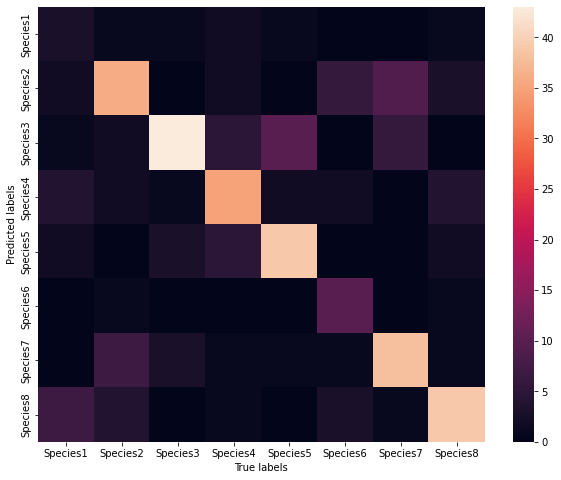

BABABA


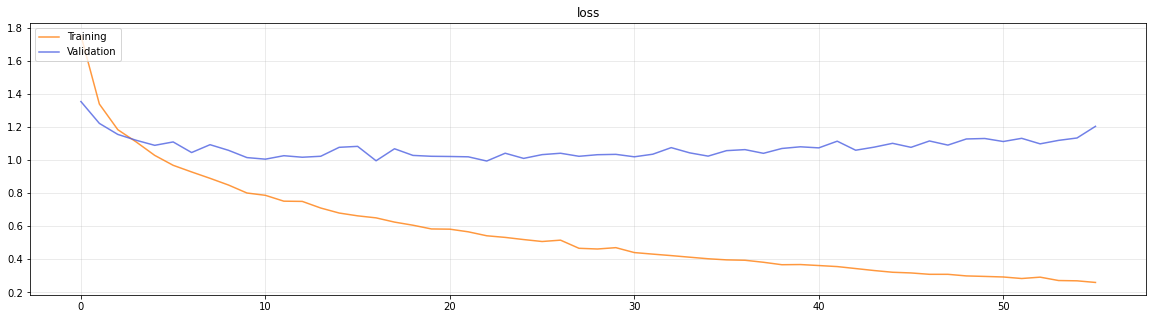

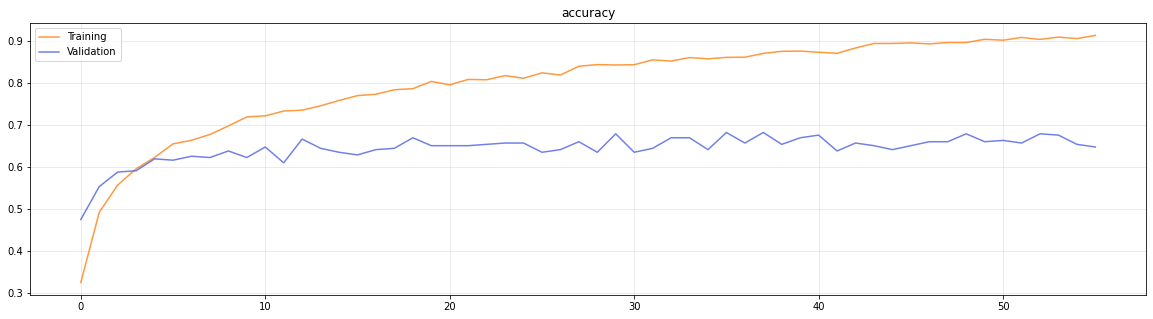

In [ ]:
model_helper.show_confusion_matrix(X_test, Y_test)
model_helper.plot_phase_train_vs_validation(history)